# 0.0 Import Libraries
* Updated Normalisation Method for Fused MASKING
* LIDAR Feature + HSI Feature, Atrention , AutoEncoder

In [ ]:
pip install spectral mat73  einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 3.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
import os
import math

from einops import rearrange
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from scipy import io
import torch.utils.data
import scipy.io as sio
import mat73
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1.0 Upload Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! ls '/content/drive/MyDrive/A02_RemoteSensingData/TrentoDataSet/'

aug_trento_best_model_weights.pth	       best_model_weights.pth
Autoencodermodel_sgdp11fused_trento.pth        cae_tr_model_state_batchscore.pth
Autoencodermodel_sgdp13fused_trento.pth        HSI_TeSet.mat
Autoencodermodel_sgdp3fused_s50000_trento.pth  HSI_TrSet.mat
Autoencodermodel_sgdp3fused_trento.pth	       LiDAR_TeSet.mat
Autoencodermodel_sgdp5fused_s50000_trento.pth  LiDAR_TrSet.mat
Autoencodermodel_sgdp5fused_trento.pth	       TeLabel.mat
Autoencodermodel_sgdp7fused_s50000_trento.pth  tr_cae_model_state.pth
Autoencodermodel_sgdp7fused_trento.pth	       trento_data.mat
Autoencodermodel_sgdp9fused_trento.pth	       TrLabel.mat
Autoencodermodel_trento.pth


In [ ]:
# path
path ='/content/drive/MyDrive/A02_RemoteSensingData/TrentoDataSet/'

In [ ]:
# path
#path ='/content/drive/MyDrive/A02_RemoteSensingData/MUUFLGUlfportDataCollection/'
# Loader HSI TR_map_2018
trento_data=sio.loadmat(path+'trento_data.mat')['HSI_data']
trento_data.shape

(166, 600, 63)

In [ ]:
# Loader HSI TR_map_2018
trento_data=sio.loadmat(path+'trento_data.mat')

# Extract the HSI_data and LiDAR_data arrays
trento_hsi_data = trento_data['HSI_data']
trento_lidar_data = trento_data['LiDAR_data']
trento_gt=trento_data['ground']
print('trento_hsi_data shape:', trento_hsi_data.shape)
print('trento_lidar_data shape:', trento_lidar_data.shape)
print('trento_gt shape:', trento_gt.shape)


trento_hsi_data shape: (166, 600, 63)
trento_lidar_data shape: (166, 600)
trento_gt shape: (166, 600)


In [ ]:
hsi_data=trento_hsi_data
lidar_data=trento_lidar_data
#gt_data=truth
print('hsi_data shap:', hsi_data.shape)
print('lidar_data shap:', lidar_data.shape)
#print('gt_data shap:', gt_data.shape)

hsi_data shap: (166, 600, 63)
lidar_data shap: (166, 600)


In [ ]:
# Expand its dimensions to make it 3D with 1 channel
lidar_data= np.expand_dims(lidar_data, axis=-1)
print('lidar_data shap:', lidar_data.shape)

lidar_data shap: (166, 600, 1)


#1.1 Extract HSI and LiDAR smaple patches

In [ ]:
import numpy as np
import scipy.io as sio

# Function to extract a patch centered at (row, col)
def extract_patch(data, row, col, size, depth):
    half_size = size // 2
    return data[row-half_size:row+half_size+1, col-half_size:col+half_size+1, :depth]

# Function to randomly generate patch locations
def generate_patch_locations(num_samples, rows, cols, patch_size):
    half_size = patch_size // 2
    locations = []
    for _ in range(num_samples):
        row = np.random.randint(half_size, rows - half_size)
        col = np.random.randint(half_size, cols - half_size)
        locations.append((row, col))
    return locations

# Define parameters
num_samples = 50000
hsi_patch_size = 3  # 9x9 patch
hsi_depth = 63     # Assuming depth is 144 as per your data
lidar_patch_size = 3
lidar_depth = 1

# Assuming hsi_2013_data and lidar_2013_data are already loaded
rows, cols, _ = hsi_data.shape

# Generate random patch locations
patch_locations = generate_patch_locations(num_samples, rows, cols, hsi_patch_size)

# Extract patches
hsi_patches = np.array([extract_patch(hsi_data, row, col, hsi_patch_size, hsi_depth) for row, col in patch_locations])
lidar_patches = np.array([extract_patch(lidar_data, row, col, lidar_patch_size, lidar_depth) for row, col in patch_locations])

print('HSI Patches shape:', hsi_patches.shape)
print('LiDAR Patches shape:', lidar_patches.shape)


HSI Patches shape: (50000, 3, 3, 63)
LiDAR Patches shape: (50000, 3, 3, 1)


In [ ]:
# Assuming lidar_2013_data is already loaded and has shape (rows, cols, 1)
# After extracting the LiDAR patches, repeat them across the depth dimension to match HSI's depth
# Extract LiDAR patches
lidar_patches_single_channel = np.array([
    extract_patch(lidar_data, row, col, lidar_patch_size, lidar_depth)
    for row, col in patch_locations
])

# Repeat the single LiDAR channel to match the number of HSI channels
lidar_patches = np.repeat(lidar_patches_single_channel, hsi_depth, axis=-1)

print('LiDAR Patches shape after repeating channels:', lidar_patches.shape)


LiDAR Patches shape after repeating channels: (50000, 3, 3, 63)


##1.2 Normalisation

In [ ]:
def normalize_hsi_patches(hsi_patches):
    # Initialize an array to store the normalized patches
    normalized_patches = np.zeros_like(hsi_patches, dtype=np.float32)

    # Iterate over each band
    for band in range(hsi_patches.shape[-1]):
        band_data = hsi_patches[:, :, :, band]
        min_val = np.min(band_data)
        max_val = np.max(band_data)

        # Normalize this band
        normalized_patches[:, :, :, band] = (band_data - min_val) / (max_val - min_val) if max_val > min_val else band_data

    return normalized_patches

normalized_hsi_patches = normalize_hsi_patches(hsi_patches)
print('normalized_hsi_patches.shape:', normalized_hsi_patches.shape)

normalized_hsi_patches.shape: (50000, 3, 3, 63)


In [ ]:
def normalize_lidar_patches(lidar_patches):
    min_val = np.min(lidar_patches)
    max_val = np.max(lidar_patches)

    return (lidar_patches - min_val) / (max_val - min_val) if max_val > min_val else lidar_patches

normalized_lidar_patches = normalize_lidar_patches(lidar_patches)
normalized_lidar_patches.shape

(50000, 3, 3, 63)

In [ ]:
# Create   Raw Data in The combiend function
import numpy as np

def process_and_normalize_data(hsi_data, lidar_data, num_samples, patch_size, hsi_depth):
    # Function to extract a patch centered at (row, col)
    def extract_patch(data, row, col, size, depth):
        half_size = size // 2
        return data[row-half_size:row+half_size+1, col-half_size:col+half_size+1, :depth]

    # Function to randomly generate patch locations
    def generate_patch_locations(num_samples, rows, cols, patch_size):
        half_size = patch_size // 2
        locations = []
        for _ in range(num_samples):
            row = np.random.randint(half_size, rows - half_size)
            col = np.random.randint(half_size, cols - half_size)
            locations.append((row, col))
        return locations

    # Generate random patch locations
    rows, cols, _ = hsi_data.shape
    patch_locations = generate_patch_locations(num_samples, rows, cols, patch_size)

    # Extract patches
    hsi_patches = np.array([extract_patch(hsi_data, row, col, patch_size, hsi_depth) for row, col in patch_locations])
    lidar_patches_single_channel = np.array([extract_patch(lidar_data, row, col, patch_size, 1) for row, col in patch_locations])
    lidar_patches = np.repeat(lidar_patches_single_channel, hsi_depth, axis=-1)

    # Normalize HSI patches
    def normalize_patches(patches):
        normalized_patches = np.zeros_like(patches, dtype=np.float32)
        for band in range(patches.shape[-1]):
            band_data = patches[:, :, :, band]
            min_val = np.min(band_data)
            max_val = np.max(band_data)
            normalized_patches[:, :, :, band] = (band_data - min_val) / (max_val - min_val) if max_val > min_val else band_data
        return normalized_patches

    normalized_hsi_patches = normalize_patches(hsi_patches)
    normalized_lidar_patches = normalize_patches(lidar_patches)

    return normalized_hsi_patches, normalized_lidar_patches

# Example usage
num_samples = 50000
hsi_patch_size = 3
hsi_depth = 63

# Assuming hsi_2013_data and lidar_2013_data are already loaded
normalized_hsi_patches, normalized_lidar_patches = process_and_normalize_data(hsi_data, lidar_data, num_samples, hsi_patch_size, hsi_depth)

print('Normalized HSI Patches shape:', normalized_hsi_patches.shape)
print('Normalized LiDAR Patches shape:', normalized_lidar_patches.shape)


Normalized HSI Patches shape: (50000, 3, 3, 63)
Normalized LiDAR Patches shape: (50000, 3, 3, 63)


#2.0 Model Building

### 2.1 Configuration

In [ ]:
# 2.1 Configuration
class Config:
    def __init__(self,in_channels,num_patches,kernel_size,patch_size,emb_size,heads,dim_head,output_dim, dropout,pos_emb_size,stride ):
        self.in_channels = in_channels
        self.num_patches = num_patches
        self.kernel_size = kernel_size
        self.patch_size = patch_size
        self.emb_size = emb_size
        self.heads = heads
        self.dim_head = dim_head
        #self.input_dim = input_dim
        self.output_dim=output_dim
        self.dropout = dropout
        self.pos_emb_size = pos_emb_size
        self.stride = stride


### 2.2 Patch Embedding

In [ ]:
# patch Embedding V1.0 When patch size is less than 13 we can use this one version
import torch
import torch.nn as nn

class PatchEmbedding(nn.Module):
    def __init__(self, config):
        super().__init__()
        # Convolution layer to create patch embeddings
        self.proj = nn.Conv2d(
            in_channels=config.in_channels,   # Number of spatial size w*h (e.g.,9*9)
            out_channels=config.emb_size,     # Number of output channels (embedding size)
            kernel_size=config.kernel_size,    # Size of the kernel (patch size)
            stride=config.stride,             # Stride for the convolution
        )
        # Positional embeddings
        self.pos_embedding = nn.Parameter(torch.zeros(1, config.num_patches , config.emb_size))

    def forward(self, x):
        B, C, H, W = x.shape
        # Apply the convolution layer to get patch embeddings
        x = self.proj(x)
        # Flatten and transpose to get the correct shape
        x = x.flatten(2).transpose(1, 2)
        # Add position embeddings to the patch embeddings
        x = x + self.pos_embedding[:, :x.size(1)]
        return x


In [ ]:
# PatchEmbedding V2.0 Dymatic to suit all patch size
class PatchEmbedding(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.proj = nn.Conv2d(
            in_channels=config.in_channels,
            out_channels=config.emb_size,
            kernel_size=config.kernel_size,
            stride=config.stride,
        )

        # Store relevant configuration parameters as attributes
        self.kernel_size = config.kernel_size
        self.stride = config.stride
        self.emb_size = config.emb_size

        # Initialize a dummy value for num_patches; will be updated in forward
        self.num_patches = 0

        # Positional embeddings will be resized in forward to match the dynamic number of patches
        self.pos_embedding = nn.Parameter(torch.zeros(1, 1, self.emb_size))

    def forward(self, x):
        B, C, H, W = x.shape

        # Dynamically compute the number of patches using stored attributes
        self.num_patches = ((H - self.kernel_size[0]) // self.stride + 1) * \
                           ((W - self.kernel_size[1]) // self.stride + 1)

        # Resize pos_embedding to match the new num_patches
        if self.pos_embedding.size(1) != self.num_patches + 1:
            self.pos_embedding = nn.Parameter(torch.zeros(1, self.num_patches + 1, self.emb_size))

        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        x = x + self.pos_embedding[:, :x.size(1)]
        return x


### 2.3 Attention Module

In [ ]:
class AttentionModule(nn.Module):
    def __init__(self, in_channels, emb_size, num_heads, dropout_rate, num_patches):
        super(AttentionModule, self).__init__()
        self.input_projection = nn.Linear(emb_size, emb_size)  # Project input to emb_size
        self.norm1 = nn.LayerNorm(emb_size)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=emb_size, num_heads=num_heads, dropout=dropout_rate)
        self.norm2 = nn.LayerNorm(emb_size)

        # Linear layers followed by ELU
        self.linear1 = nn.Linear(emb_size, emb_size)
        self.elu1 = nn.ELU()
        self.linear2 = nn.Linear(emb_size, emb_size)
        self.elu2 = nn.ELU()
        self.linear3 = nn.Linear(emb_size, num_patches)
        self.elu3 = nn.ELU()

        # Final Linear layer, projecting back to the original channel size
        self.final_linear = nn.Linear(num_patches,in_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.input_projection(x)  # Project input to emb_size

        # Apply normalization
        x_norm = self.norm1(x)

        # Apply multi-head attention
        attn_output, _ = self.multihead_attn(x_norm, x_norm, x_norm)

        # Apply the second normalization
        attn_output_norm = self.norm2(attn_output + x)

        # Apply the first linear layer and ELU activation
        x_linear1 = self.linear1(attn_output_norm)
        x_elu1 = self.elu1(x_linear1)

        # Apply the second linear layer and ELU activation
        x_linear2 = self.linear2(x_elu1)
        x_elu2 = self.elu2(x_linear2)

        # Apply the third linear layer and ELU activation
        x_linear3 = self.linear3(x_elu2)
        x_elu3 = self.elu3(x_linear3)

        # Apply the final linear layer and Sigmoid activation
        x_final_linear = self.final_linear(x_elu3)
        x_sigmoid = self.sigmoid(x_final_linear)

        return x_sigmoid


### 2.4. CNNAutoEncoder-AVGPooling

In [ ]:
class CNNAutoEncoder(nn.Module):
    def __init__(self, config):
        super(CNNAutoEncoder, self).__init__()

        self.patch_size = config.patch_size

        # Encoder
        self.conv1 = nn.Conv2d(in_channels=config.in_channels, out_channels=config.emb_size,
                               kernel_size=config.kernel_size, stride=config.stride, padding=1)
        self.elu1 = nn.ELU()
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=config.emb_size, out_channels=config.output_dim,
                               kernel_size=config.kernel_size, stride=config.stride, padding=1)
        self.elu2 = nn.ELU()
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        # Decoder
        self.deconv1 = nn.ConvTranspose2d(in_channels=config.output_dim, out_channels=config.emb_size,
                                          kernel_size=config.kernel_size, stride=2, padding=1, output_padding=1)
        self.elu3 = nn.ELU()

        self.deconv2 = nn.ConvTranspose2d(in_channels=config.emb_size, out_channels=config.in_channels,
                                          kernel_size=config.kernel_size, stride=2, padding=1, output_padding=1)
        self.elu4 = nn.ELU()

    def forward(self, x):
        # Encoding
        x = self.elu1(self.conv1(x))
        x = self.pool1(x)

        x = self.elu2(self.conv2(x))
        x = self.pool2(x)

        # Decoding
        x = self.elu3(self.deconv1(x))
        x = self.elu4(self.deconv2(x))

        # Resize to the original size
        x = F.interpolate(x, size=(self.patch_size, self.patch_size), mode='nearest')

        return x


### 2.5 HSIAttentionSubmodel

In [ ]:
class HSIAttentionSubmodel(nn.Module):
    def __init__(self, hsi_config):
        super(HSIAttentionSubmodel, self).__init__()
        self.patch_embedding = PatchEmbedding(hsi_config)
        self.attention_module = AttentionModule(
            in_channels=hsi_config.in_channels,
            emb_size=hsi_config.emb_size,
            num_heads=hsi_config.heads,
            dropout_rate=hsi_config.dropout,
            num_patches=hsi_config.num_patches
        )
    def forward(self, x):
        # Process through patch embedding
        x = self.patch_embedding(x)
        # Process through attention module
        x = self.attention_module(x)
        return x

### 2.6 LiDARAttentionSubmodel

In [ ]:
class LiDARAttentionSubmodel(nn.Module):
    def __init__(self, hsi_config):
        super(LiDARAttentionSubmodel, self).__init__()
        self.patch_embedding = PatchEmbedding(lidar_config)
        self.attention_module = AttentionModule(
            in_channels=lidar_config.in_channels,
            emb_size=lidar_config.emb_size,
            num_heads=lidar_config.heads,
            dropout_rate=lidar_config.dropout,
            num_patches=lidar_config.num_patches
        )
    def forward(self, x):
        # Process through patch embedding
        x = self.patch_embedding(x)

        # Process through attention module
        x = self.attention_module(x)
        return x

### 2.7 Integrated Model

In [ ]:
class IntegratedModel(nn.Module):
    def __init__(self, hsi_config, lidar_config):
        super(IntegratedModel, self).__init__()
        self.hsi_attention_submodel = HSIAttentionSubmodel(hsi_config)
        self.lidar_attention_submodel = LiDARAttentionSubmodel(lidar_config)
        self.autoencoder = CNNAutoEncoder(hsi_config)  # Pass the configuration here

    def forward(self, hsi_sample, lidar_sample):
        # Process through attention submodels
        hsi_attention_output = self.hsi_attention_submodel(hsi_sample)
        lidar_attention_output = self.lidar_attention_submodel(lidar_sample)

        #Add Lidar to HSI sample To assure the autoencoder input to have lidar also
        hsi_sample=hsi_sample+lidar_sample

        # Flatten and transpose the HSI sample to match the attention mask shape
        hsi_sample_flattened = hsi_sample.view(hsi_sample.shape[0], hsi_sample.shape[1], -1)

        # Fuse the HSI and LiDAR attention outputs
        fused_attention_output = hsi_attention_output + lidar_attention_output
        fused_attention_output_transposed = fused_attention_output.transpose(1, 2)

        # Element-wise multiplication
        elementwise_result = hsi_sample_flattened * fused_attention_output_transposed

        num_samples, num_channels, height, width = hsi_sample.shape
        # This needs to be consistent with the actual size of elementwise_result
        new_height, new_width = height, width  # adjust as needed

        # Reshape for input into the autoencoder
        autoencoder_input = elementwise_result.view(num_samples, num_channels, new_height, new_width)

        # Pass through the autoencoder
        autoencoder_output = self.autoencoder(autoencoder_input)

        return fused_attention_output,autoencoder_input, autoencoder_output

# 3.0 LossFuntion

In [ ]:
class CustomLoss(nn.Module):
    def __init__(self, lambda1):
        super(CustomLoss, self).__init__()
        self.lambda1 = lambda1

    def forward(self, autoencoder_output, autoencoder_input, fused_mask):
        # Calculate the reconstruction loss (e.g., MSE loss) between the autoencoder's output and the modified input
        recon_loss = F.mse_loss(autoencoder_output, autoencoder_input)

        # Calculate the sparsity loss based on the fused_mask
        sparsity_loss = torch.sum(torch.sqrt(torch.sum(fused_mask ** 2, dim=2))) * self.lambda1

        # Combine the losses
        total_loss = 0.5 * recon_loss + sparsity_loss
        return total_loss


### 3.4 Created Different Size data

In [ ]:
# Create   Raw Data in The combiend function
import numpy as np

def process_and_normalize_data(hsi_data, lidar_data, num_samples, patch_size, hsi_depth):
    # Function to extract a patch centered at (row, col)
    def extract_patch(data, row, col, size, depth):
        half_size = size // 2
        return data[row-half_size:row+half_size+1, col-half_size:col+half_size+1, :depth]

    # Function to randomly generate patch locations
    def generate_patch_locations(num_samples, rows, cols, patch_size):
        half_size = patch_size // 2
        locations = []
        for _ in range(num_samples):
            row = np.random.randint(half_size, rows - half_size)
            col = np.random.randint(half_size, cols - half_size)
            locations.append((row, col))
        return locations

    # Generate random patch locations
    rows, cols, _ = hsi_data.shape
    patch_locations = generate_patch_locations(num_samples, rows, cols, patch_size)

    # Extract patches
    hsi_patches = np.array([extract_patch(hsi_data, row, col, patch_size, hsi_depth) for row, col in patch_locations])
    lidar_patches_single_channel = np.array([extract_patch(lidar_data, row, col, patch_size, 1) for row, col in patch_locations])
    lidar_patches = np.repeat(lidar_patches_single_channel, hsi_depth, axis=-1)

    # Normalize HSI patches
    def normalize_patches(patches):
        normalized_patches = np.zeros_like(patches, dtype=np.float32)
        for band in range(patches.shape[-1]):
            band_data = patches[:, :, :, band]
            min_val = np.min(band_data)
            max_val = np.max(band_data)
            normalized_patches[:, :, :, band] = (band_data - min_val) / (max_val - min_val) if max_val > min_val else band_data
        return normalized_patches

    normalized_hsi_patches = normalize_patches(hsi_patches)
    normalized_lidar_patches = normalize_patches(lidar_patches)

    return normalized_hsi_patches, normalized_lidar_patches

# Example usage
num_samples = 50000
hsi_patch_size = 11
hsi_depth = 63

# Assuming hsi_2013_data and lidar_2013_data are already loaded
normalized_hsi_patches, normalized_lidar_patches = process_and_normalize_data(hsi_data, lidar_data, num_samples, hsi_patch_size, hsi_depth)

print('Normalized HSI Patches shape:', normalized_hsi_patches.shape)
print('Normalized LiDAR Patches shape:', normalized_lidar_patches.shape)


Normalized HSI Patches shape: (50000, 11, 11, 63)
Normalized LiDAR Patches shape: (50000, 11, 11, 63)


### 3.5  configuration forIntegrated Model

In [ ]:
# Hsi configuration
hsi_config = Config(
    in_channels=63,  # Each sample covers 144 bands
    num_patches=63,  # Channeles to patch number
    kernel_size=(1,1),  # Adjusted to match new patch size
    patch_size=11,  # Adjusted to match new patch size (5*5, 144/24=6)
    emb_size=128,  # Embedding size, this can be changed
    heads=8,  # Number of attention heads, this can be changed
    dim_head=32,  # Dimension of each attention head, this can be changed
    output_dim=128,
    dropout=0.2,  # Dropout rate, this can be changed
    pos_emb_size=128,  # Position embedding size, this can be changed
    stride=1  # Stride for the convolution, this can be changed
)


# Lidara configuration
lidar_config = Config(
    in_channels=63,  # lidar group has 1 channels
    num_patches=63,  # 1 band for Lidar
    kernel_size=(1,1),  # Adjusted to match new patch size
    patch_size=11, # Adjusted to match new patch size
    emb_size=128,  # Embedding size, this can be changed
    heads=8,  # Number of attention heads, this can be changed
    dim_head=32,  # Dimension of each attention head, this can be changed
    output_dim=128,
    dropout=0.2,  # Dropout rate, this can be changed
    pos_emb_size=128,  # Position embedding size, this can be changed
    stride=1 # Stride for the convolution, this can be changed
)
# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 4.0 Training Data Preparation

In [ ]:
# Select one sample patch
sample_hsi_patch = normalized_hsi_patches # First patch for demonstration
sample_lidar_patch = normalized_lidar_patches

# Convert patches to float32
sample_hsi_patch = sample_hsi_patch.astype(np.float32)
sample_lidar_patch = sample_lidar_patch.astype(np.float32)

print('sample_hsi_patch shape:', sample_hsi_patch.shape)
print('sample_lidar_patch shape:', sample_lidar_patch.shape)

# Reshape patches to match the input shape expected by the model
# (Batch size, Channels, Height, Width)
sample_hsi_patch = np.transpose(sample_hsi_patch, (0, 3, 1, 2))  # Rearrange dimensions to (5000, 144, 9, 9)
sample_lidar_patch = np.transpose(sample_lidar_patch, (0, 3, 1, 2))  # Rearrange dimensions to (5000, 144, 9, 9)
print('sample_hsi_patch_transpose shape:', sample_hsi_patch.shape)
print('sample_lidar_patch_transpose shape:', sample_lidar_patch.shape)

# Convert patches to PyTorch tensors
sample_hsi_patch_tensor = torch.tensor(sample_hsi_patch)
sample_lidar_patch_tensor = torch.tensor(sample_lidar_patch)
print('sample_hsi_patch_tensorshape:', sample_hsi_patch_tensor.shape)
print('sample_lidar_patch_tensoshape:', sample_lidar_patch_tensor.shape)


sample_hsi_patch shape: (50000, 11, 11, 63)
sample_lidar_patch shape: (50000, 11, 11, 63)
sample_hsi_patch_transpose shape: (50000, 63, 11, 11)
sample_lidar_patch_transpose shape: (50000, 63, 11, 11)
sample_hsi_patch_tensorshape: torch.Size([50000, 63, 11, 11])
sample_lidar_patch_tensoshape: torch.Size([50000, 63, 11, 11])


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# Select one sample patch
sample_hsi_patch = normalized_hsi_patches # First patch for demonstration
sample_lidar_patch = normalized_lidar_patches
# sample_hsi_patch = hsi_patches # First patch for demonstration
# sample_lidar_patch = lidar_patches

# Convert patches to float32
sample_hsi_patch = sample_hsi_patch.astype(np.float32)
sample_lidar_patch = sample_lidar_patch.astype(np.float32)
print('sample_hsi_patch shape:', sample_hsi_patch.shape)
print('sample_lidar_patch shape:', sample_lidar_patch.shape)


# Convert patches to PyTorch tensors
sample_hsi_patch_tensor = torch.tensor(sample_hsi_patch)
sample_lidar_patch_tensor = torch.tensor(sample_lidar_patch)
print('sample_hsi_patch_tensorshape:', sample_hsi_patch_tensor.shape)
print('sample_lidar_patch_tensoshape:', sample_lidar_patch_tensor.shape)

# Now reshape HSI data such that spatial dimensions (9x9) are flattened and treated as channels
hsi_batch_flat = torch.from_numpy(sample_hsi_patch.astype(np.float32).reshape(sample_hsi_patch_tensor.shape[0], hsi_config.in_channels, hsi_config.patch_size*hsi_config.patch_size, 1)).to(device)
lidar_batch_flat = torch.from_numpy(sample_lidar_patch.astype(np.float32).reshape(sample_lidar_patch_tensor.shape[0], lidar_config.in_channels, lidar_config.patch_size*lidar_config.patch_size, 1)).to(device)
print('hsi_batch_flat shape:', hsi_batch_flat.shape)
print('lidar_batch_flat shape:', lidar_batch_flat.shape)

hsi_batch_flat = hsi_batch_flat.to(device)  # Move the tensor to GPU
lidar_batch_flat = lidar_batch_flat.to(device)  # Move the tensor to GPU

# Calculate the number of samples for training and testing
num_train_samples = int(0.8 * num_samples)
num_test_samples = num_samples - num_train_samples

# First, split into initial train and test sets
hsi_initial_train, hsi_test, lidar_initial_train, lidar_test = train_test_split(
    sample_hsi_patch_tensor, sample_lidar_patch_tensor, test_size=num_test_samples, random_state=42)

# Further split the initial training set into actual training and validation sets
hsi_train, hsi_val, lidar_train, lidar_val = train_test_split(
    hsi_initial_train, lidar_initial_train, test_size=0.15, random_state=42)  # 0.25 x 0.8 = 0.2 of the original dataset

print('hsi_train shape:', hsi_train.shape)
print('hsi_val shape:', hsi_val.shape)

# Reshape and transpose the training, validation, and testing sets
hsi_train = hsi_train.permute(0, 3, 1, 2)  # Reshape to [3000, 144, 9, 9]
hsi_val = hsi_val.permute(0, 3, 1, 2)      # Reshape to [1000, 144, 9, 9]
hsi_test = hsi_test.permute(0, 3, 1, 2)    # Apply similar transformation to test set
print('hsi_train shape after permuted:', hsi_train.shape)
print('hsi_val shape after permuted:', hsi_val.shape)
print('hsi_test shape after permuted:', hsi_test.shape)

lidar_train = lidar_train.permute(0, 3, 1, 2)  # Apply similar transformation
lidar_val = lidar_val.permute(0, 3, 1, 2)      # Apply similar transformation
lidar_test = lidar_test.permute(0, 3, 1, 2)    # Apply similar transformation
print('lidar_train shape after permuted:', lidar_train.shape)
print('lidar_val shape after permuted:', lidar_val.shape)
print('lidar_test shape after permuted:', lidar_test.shape)

# Create TensorDatasets for training, validation, and testing sets
hsi_train_dataset = TensorDataset(hsi_train)
hsi_val_dataset = TensorDataset(hsi_val)
hsi_test_dataset = TensorDataset(hsi_test)

lidar_train_dataset = TensorDataset(lidar_train)
lidar_val_dataset = TensorDataset(lidar_val)
lidar_test_dataset = TensorDataset(lidar_test)

# Create DataLoaders for each set
hsi_train_dataloader = DataLoader(hsi_train_dataset, batch_size=32, shuffle=True)
hsi_val_dataloader = DataLoader(hsi_val_dataset, batch_size=32, shuffle=False)
hsi_test_dataloader = DataLoader(hsi_test_dataset, batch_size=32, shuffle=False)

lidar_train_dataloader = DataLoader(lidar_train_dataset, batch_size=32, shuffle=True)
lidar_val_dataloader = DataLoader(lidar_val_dataset, batch_size=32, shuffle=False)
lidar_test_dataloader = DataLoader(lidar_test_dataset, batch_size=32, shuffle=False)

# Now you have separate dataloaders for train, val, and test datasets


sample_hsi_patch shape: (50000, 11, 11, 63)
sample_lidar_patch shape: (50000, 11, 11, 63)
sample_hsi_patch_tensorshape: torch.Size([50000, 11, 11, 63])
sample_lidar_patch_tensoshape: torch.Size([50000, 11, 11, 63])
hsi_batch_flat shape: torch.Size([50000, 63, 121, 1])
lidar_batch_flat shape: torch.Size([50000, 63, 121, 1])
hsi_train shape: torch.Size([34000, 11, 11, 63])
hsi_val shape: torch.Size([6000, 11, 11, 63])
hsi_train shape after permuted: torch.Size([34000, 63, 11, 11])
hsi_val shape after permuted: torch.Size([6000, 63, 11, 11])
hsi_test shape after permuted: torch.Size([10000, 63, 11, 11])
lidar_train shape after permuted: torch.Size([34000, 63, 11, 11])
lidar_val shape after permuted: torch.Size([6000, 63, 11, 11])
lidar_test shape after permuted: torch.Size([10000, 63, 11, 11])


# 5.0 Training Model

In [ ]:
# Hyperparameters
num_epochs = 10
learning_rate = 0.0001
batch_size = 32
lambda1_value = 0.5 # Custom loss lambda value

# Initialize the model
model = IntegratedModel(hsi_config, lidar_config).to(device)

# Initialize the custom loss function
# Instantiate CustomLoss with the submodels and lambda value
custom_loss_function = CustomLoss(lambda1_value)
criterion = CustomLoss(lambda1_value).to(device)

# Optimizer
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # optimizer 1
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)  # optimizer 2
#optimizer=torch.optim.RMSprop(model.parameters(), lr=learning_rate) #optimizer 3
#optimizer=torch.optim.AdamW(model.parameters(), lr=learning_rate) #optimizer 4


def train_model(model, criterion, optimizer, num_epochs, hsi_train_dataloader, lidar_train_dataloader, device, early_stopping_patience):
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for (hsi_patches,), (lidar_patches,) in zip(hsi_train_dataloader, lidar_train_dataloader):
            hsi_patches, lidar_patches = hsi_patches.to(device), lidar_patches.to(device)

            optimizer.zero_grad()
            fused_attention_output, autoencoder_input, autoencoder_output = model(hsi_patches, lidar_patches)
            loss = custom_loss_function(autoencoder_output, autoencoder_input, fused_attention_output)
            #loss = criterion(autoencoder_output, hsi_patches)  # Adjust the loss function as needed
            train_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        train_loss /= len(hsi_train_dataloader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for (hsi_patches,), (lidar_patches,) in zip(hsi_val_dataloader, lidar_val_dataloader):
                hsi_patches, lidar_patches = hsi_patches.to(device), lidar_patches.to(device)
                fused_attention_output, autoencoder_input, autoencoder_output = model(hsi_patches, lidar_patches)
                loss = custom_loss_function(autoencoder_output, autoencoder_input, fused_attention_output)
                val_loss += loss.item()

        val_loss /= len(hsi_val_dataloader)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == early_stopping_patience:
                print("Early stopping triggered.")
                break

# Example usage
early_stopping_patience = 10
train_model(model, custom_loss_function, optimizer, num_epochs, hsi_train_dataloader, lidar_train_dataloader, device, early_stopping_patience)


Epoch [1/10], Train Loss: 13804.2691, Val Loss: 11479.8817
Epoch [2/10], Train Loss: 7831.5263, Val Loss: 3830.4183
Epoch [3/10], Train Loss: 1307.8162, Val Loss: 86.7236
Epoch [4/10], Train Loss: 13.6054, Val Loss: 0.0349
Epoch [5/10], Train Loss: 0.0148, Val Loss: 0.0076
Epoch [6/10], Train Loss: 0.0061, Val Loss: 0.0048
Epoch [7/10], Train Loss: 0.0044, Val Loss: 0.0038
Epoch [8/10], Train Loss: 0.0036, Val Loss: 0.0032
Epoch [9/10], Train Loss: 0.0031, Val Loss: 0.0029
Epoch [10/10], Train Loss: 0.0028, Val Loss: 0.0026


In [ ]:
path ='/content/drive/MyDrive/A02_RemoteSensingData/TrentoDataSet/'
def save_model(model, optimizer, path):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, path)

# Example usage:
model_path = path+'Autoencodermodel_sgdp11fused_s50000_trento.pth'  # Adjust path as needed
save_model(model, optimizer, model_path)


In [ ]:
import torch
import torch.nn as nn
# Assuming IntegratedModel, HSIAttentionSubmodel, LiDARAttentionSubmodel, CNNAutoEncoder are defined
# Create an instance of your model
model = IntegratedModel(hsi_config, lidar_config)

# Define the path where your model is saved
model_path = path+'Autoencodermodel_sgdp11fused_s50000_trento.pth' # Update the path accordingly

# Load the state dictionary
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])

# Optionally, if you want to evaluate the model
model.eval()

# Print the parameters
for name, param in model.named_parameters():
    print(name, param.shape)

# Print the full state dictionary
print("Full state dict:")
print(model.state_dict())


hsi_attention_submodel.patch_embedding.pos_embedding torch.Size([1, 1, 128])
hsi_attention_submodel.patch_embedding.proj.weight torch.Size([128, 63, 1, 1])
hsi_attention_submodel.patch_embedding.proj.bias torch.Size([128])
hsi_attention_submodel.attention_module.input_projection.weight torch.Size([128, 128])
hsi_attention_submodel.attention_module.input_projection.bias torch.Size([128])
hsi_attention_submodel.attention_module.norm1.weight torch.Size([128])
hsi_attention_submodel.attention_module.norm1.bias torch.Size([128])
hsi_attention_submodel.attention_module.multihead_attn.in_proj_weight torch.Size([384, 128])
hsi_attention_submodel.attention_module.multihead_attn.in_proj_bias torch.Size([384])
hsi_attention_submodel.attention_module.multihead_attn.out_proj.weight torch.Size([128, 128])
hsi_attention_submodel.attention_module.multihead_attn.out_proj.bias torch.Size([128])
hsi_attention_submodel.attention_module.norm2.weight torch.Size([128])
hsi_attention_submodel.attention_module

In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


Model's state_dict:
hsi_attention_submodel.patch_embedding.pos_embedding 	 torch.Size([1, 1, 128])
hsi_attention_submodel.patch_embedding.proj.weight 	 torch.Size([128, 63, 1, 1])
hsi_attention_submodel.patch_embedding.proj.bias 	 torch.Size([128])
hsi_attention_submodel.attention_module.input_projection.weight 	 torch.Size([128, 128])
hsi_attention_submodel.attention_module.input_projection.bias 	 torch.Size([128])
hsi_attention_submodel.attention_module.norm1.weight 	 torch.Size([128])
hsi_attention_submodel.attention_module.norm1.bias 	 torch.Size([128])
hsi_attention_submodel.attention_module.multihead_attn.in_proj_weight 	 torch.Size([384, 128])
hsi_attention_submodel.attention_module.multihead_attn.in_proj_bias 	 torch.Size([384])
hsi_attention_submodel.attention_module.multihead_attn.out_proj.weight 	 torch.Size([128, 128])
hsi_attention_submodel.attention_module.multihead_attn.out_proj.bias 	 torch.Size([128])
hsi_attention_submodel.attention_module.norm2.weight 	 torch.Size([1

# 6. Band Selection based on Applied Trained Model and Clustering

In [ ]:
# Create an instance of your model
model = IntegratedModel(hsi_config, lidar_config)

# Define the path where your model is saved
model_path = path+'Autoencodermodel_sgdp11fused_s50000_trento.pth' # Update the path accordingly

# Load the state dictionary
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])

# Optionally, if you want to evaluate the model
model.eval()

# List to store fused masks
all_fused_masks = []

# Process each pair of DataLoaders (HSI and LiDAR for train, val, test)
dataloaders = zip([hsi_train_dataloader, hsi_val_dataloader, hsi_test_dataloader],
                  [lidar_train_dataloader, lidar_val_dataloader, lidar_test_dataloader])

for hsi_loader, lidar_loader in dataloaders:
    with torch.no_grad():
        for hsi_patches, lidar_patches in zip(hsi_loader, lidar_loader):
            hsi_patches = hsi_patches[0].to(device)  # Unpack and move to device
            lidar_patches = lidar_patches[0].to(device)  # Unpack and move to device
            fused_mask, _,_ = model(hsi_patches, lidar_patches)
            all_fused_masks.append(fused_mask.cpu().numpy())

# Concatenate all fused masks
all_fused_masks = np.concatenate(all_fused_masks, axis=0)
print('all_fused_masks.shape:', all_fused_masks.shape)

# Compute the mean attention value across all samples and spatial locations for each band
# This will result in a vector A of length 144, where each Ai is the aggregated attention score for the i-th band
A = all_fused_masks.mean(axis=(0, 1))

# Normalize the aggregated attention scores to ensure they are on a comparable scale
A_norm = (A - A.min()) / (A.max() - A.min())

A_norm  # This is the normalized attention for each band
print('A_norm shape:', A_norm.shape)


all_fused_masks.shape: (50000, 121, 63)
A_norm shape: (63,)


correlation_matrix shape: (63, 63)


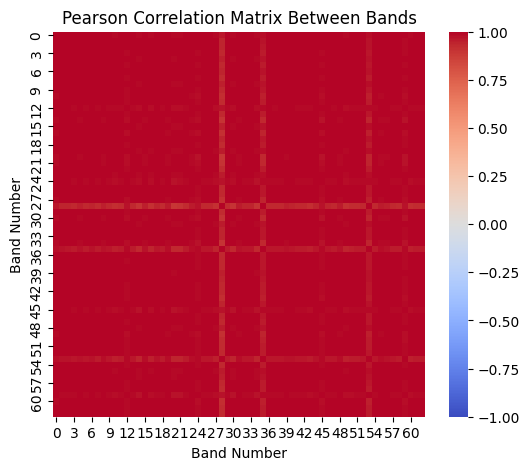

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'all_fused_masks' is available with shape (5000, 81, 144)
# Reshape to (5000*81, 144) for correlation computation
band_data = all_fused_masks.reshape(-1, all_fused_masks.shape[-1])

# Compute the Pearson Correlation Matrix across bands
correlation_matrix = np.corrcoef(band_data, rowvar=False)
print('correlation_matrix shape:', correlation_matrix.shape)
# Plot the correlation matrix using seaborn's heatmap function
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Pearson Correlation Matrix Between Bands')
plt.xlabel('Band Number')
plt.ylabel('Band Number')
plt.show()


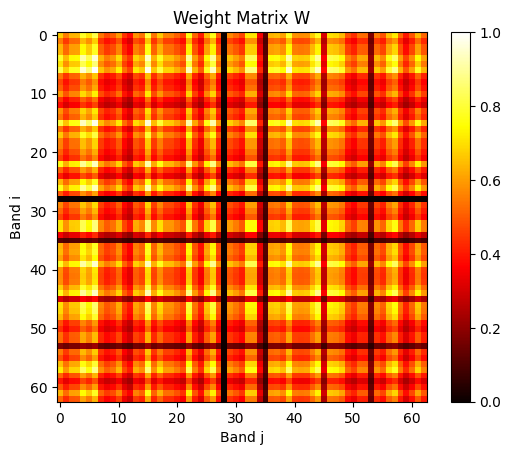

Attention matrix shape: (63, 63)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Sample normalized attention scores for each band
attention_scores = A_norm  # Normalize to sum to 1

# Calculate Weight Matrix W
num_bands = attention_scores.shape[0]
#W = np.zeros((num_bands, num_bands))
attention_distance_matrix = np.outer(A_norm, A_norm)
W = np.outer(A_norm, A_norm)

for i in range(num_bands):
    for j in range(num_bands):
        W[i, j] = attention_scores[i] *  attention_scores[j]
        #W[i, j] = (1 - attention_scores[i]) * (1 - attention_scores[j])

# Plot the Weight Matrix
plt.imshow(W, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Weight Matrix W')
plt.xlabel('Band j')
plt.ylabel('Band i')
plt.show()

print('Attention matrix shape:', W.shape)

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans
import numpy as np

# Assuming 'correlation_matrix' and 'A_norm' are defined earlier in your code
def calculate_combined_distance(A_norm, correlation_matrix, alpha=0.8, beta=0.2):
    # Using A_norm directly as it represents high attention
    attention_distance_matrix = np.outer(A_norm, A_norm)

    # Dissimilarity distance based on correlation
    dissimilarity_distance = 1 - abs(correlation_matrix)

    # Combined distance
    combined_distance = alpha * attention_distance_matrix + beta * dissimilarity_distance
    return combined_distance # he combined distance in this version is a weighted sum where higher attention and higher dissimilarity (lower correlation) are favored.

# def calculate_combined_distance(A_norm, correlation_matrix, alpha=0.8, beta=0.2):
#     # Attention distance: Higher attention should lead to a lower distance
#     attention_distance = 1 - A_norm

#     # Dissimilarity distance based on correlation
#     dissimilarity_distance = 1 - correlation_matrix

#     # Adjusting the dimensions of attention distance to match the correlation matrix
#     attention_distance_matrix = np.outer(attention_distance, attention_distance)

#     # Combined distance
#     combined_distance = alpha * attention_distance_matrix + beta * dissimilarity_distance
#     return combined_distance  (low attention_bands)


# Define multiple seeds for K-means
#seeds = [42, 0, 123]  # Example seed values
seeds = [42]  # seed values
# List of different values of k
k_values = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

for k in k_values:
    print(f"\n-- For k = {k} --")
    all_selected_bands = []

    for seed in seeds:
        combined_distance = calculate_combined_distance(A_norm, correlation_matrix, alpha=0.6, beta=0.2)

        # Apply K-means clustering
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=seed)
        kmeans.fit(combined_distance)
        clusters = kmeans.labels_

        # Select bands for the current seed
        selected_bands = []
        for cluster_idx in range(k):
            cluster_members = np.where(clusters == cluster_idx)[0]
            if cluster_members.size > 0:
                # Select the band with the highest attention within this cluster
                selected_band = cluster_members[np.argmax(A_norm[cluster_members])]
                selected_bands.append(selected_band)

        # Store the selected bands for the current seed
        all_selected_bands.append(np.array(selected_bands))

    # Print selected bands for each seed
    for idx, selected_bands in enumerate(all_selected_bands):
        print(f"Selected bands for seed {seeds[idx]}: {selected_bands.tolist()}")


-- For k = 1 --
Selected bands for seed 42: [6]

-- For k = 5 --
Selected bands for seed 42: [10, 57, 53, 11, 6]

-- For k = 10 --
Selected bands for seed 42: [17, 34, 9, 6, 28, 10, 57, 1, 53, 11]

-- For k = 15 --
Selected bands for seed 42: [4, 51, 35, 56, 34, 57, 29, 21, 38, 28, 6, 27, 47, 24, 53]

-- For k = 20 --
Selected bands for seed 42: [38, 8, 28, 4, 45, 47, 16, 35, 52, 24, 56, 57, 53, 6, 13, 9, 34, 12, 29, 11]

-- For k = 25 --


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Selected bands for seed 42: [28, 29, 4, 24, 43, 35, 9, 45, 32, 25, 53, 51, 13, 8, 6, 12, 54, 11, 34, 44, 38, 56, 57, 47, 55]

-- For k = 30 --
Selected bands for seed 42: [51, 43, 35, 4, 12, 11, 41, 28, 25, 53, 57, 55, 45, 15, 18, 38, 24, 32, 34, 44, 9, 21, 56, 6, 62, 8, 16, 10, 13, 47]

-- For k = 35 --
Selected bands for seed 42: [55, 32, 53, 13, 34, 44, 28, 56, 11, 51, 6, 35, 59, 18, 17, 45, 62, 8, 4, 38, 25, 12, 16, 47, 43, 15, 9, 21, 10, 57, 1, 41, 24, 5, 27]

-- For k = 40 --


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Selected bands for seed 42: [10, 53, 44, 50, 51, 43, 28, 45, 25, 15, 49, 18, 32, 12, 35, 59, 34, 20, 13, 16, 27, 4, 8, 56, 38, 47, 6, 21, 29, 1, 24, 57, 5, 62, 41, 37, 55, 11, 17, 9]

-- For k = 45 --
Selected bands for seed 42: [32, 24, 53, 16, 25, 4, 28, 8, 45, 13, 9, 35, 0, 15, 12, 58, 50, 34, 29, 38, 37, 44, 47, 6, 55, 51, 1, 5, 57, 10, 21, 18, 49, 27, 30, 59, 17, 26, 20, 41, 43, 2, 62, 56, 11]

-- For k = 50 --


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Selected bands for seed 42: [38, 21, 35, 4, 1, 5, 34, 28, 25, 58, 53, 59, 41, 43, 6, 50, 45, 27, 44, 12, 7, 56, 57, 15, 13, 52, 8, 47, 18, 49, 10, 24, 17, 29, 55, 48, 26, 9, 11, 32, 51, 30, 16, 0, 46, 37, 62, 60, 2, 20]


### Test on Jan. 25.2024 based on Updated architecture an Fused HSI+LIDAR as input of AUtoencoder

In [ ]:
# p=3, n=30000, sgd, lr=0.0001
top_1_seed42= [61]
top_5_seed42= [61, 28, 21, 29, 44]
top_10_seed42= [59, 2, 13, 30, 21, 61, 37, 4, 17, 28]
top_15_seed42= [51, 21, 28, 29, 44, 13, 61, 2, 54, 17, 0, 22, 60, 24, 37]
top_20_seed42= [8, 9, 2, 7, 54, 21, 27, 61, 28, 57, 29, 60, 26, 30, 37, 31, 44, 25, 51, 17]
top_25_seed42= [40, 36, 21, 31, 44, 54, 2, 61, 27, 16, 9, 60, 30, 8, 26, 29, 11, 50, 25, 17, 24, 28, 51, 22, 37]
top_30_seed42=  [36, 24, 21, 22, 8, 2, 34, 61, 27, 16, 30, 18, 59, 37, 51, 44, 31, 25, 28, 40, 19, 53, 60, 57, 29, 50, 54, 26, 9, 17]
top_35_seed42= [8, 18, 21, 40, 55, 2, 61, 36, 30, 46, 0, 22, 11, 60, 59, 44, 25, 17, 51, 31, 28, 26, 24, 34, 29, 50, 39, 57, 54, 19, 37, 3, 9, 16, 27]
top_40_seed42= [40, 36, 21, 0, 49, 18, 22, 2, 61, 16, 34, 30, 37, 44, 4, 19, 59, 13, 24, 60, 6, 28, 55, 54, 50, 17, 8, 46, 29, 26, 11, 31, 9, 57, 27, 3, 52, 39, 25, 51]
top_45_seed42= [34, 26, 21, 22, 2, 19, 36, 3, 61, 57, 59, 44, 18, 49, 40, 30, 0, 53, 37, 47, 43, 28, 60, 51, 50, 54, 9, 29, 8, 55, 4, 11, 17, 25, 39, 31, 27, 6, 35, 52, 13, 46, 24, 16, 45]
top_50_seed42= [28, 24, 21, 50, 61, 53, 60, 41, 2, 18, 19, 15, 37, 30, 59, 58, 40, 25, 4, 44, 36, 22, 34, 57, 54, 9, 17, 3, 11, 26, 29, 31, 27, 55, 39, 35, 6, 7, 49, 51, 45, 16, 32, 0, 46, 13, 8, 10, 43, 52]

In [ ]:
# p=5, n=30000, sgd, lr=0.0001
top_1_seed42= [58]
top_5_seed42= [30, 19, 26, 58, 42]
top_10_seed42= [42, 50, 30, 52, 58, 48, 19, 26, 8, 34]
top_15_seed42= [48, 52, 12, 8, 30, 50, 26, 19, 42, 34, 58, 56, 45, 28, 21]
top_20_seed42= [58, 8, 50, 56, 52, 41, 26, 22, 42, 19, 43, 21, 48, 28, 17, 13, 30, 12, 5, 55]
top_25_seed42=  [30, 52, 60, 19, 55, 37, 26, 50, 8, 12, 17, 5, 16, 28, 58, 24, 43, 41, 56, 13, 48, 22, 42, 21, 54]
top_30_seed42=  [30, 52, 6, 19, 12, 41, 44, 26, 34, 50, 35, 21, 58, 48, 1, 17, 22, 13, 43, 56, 60, 8, 27, 16, 55, 42, 5, 49, 28, 37]
top_35_seed42=  [54, 16, 52, 43, 50, 37, 19, 6, 26, 56, 17, 22, 58, 44, 13, 21, 38, 35, 41, 30, 1, 33, 42, 55, 48, 27, 57, 8, 12, 34, 5, 23, 28, 60, 45]
top_40_seed42=  [18, 19, 21, 35, 26, 52, 38, 50, 17, 7, 22, 37, 30, 43, 58, 49, 13, 56, 6, 48, 42, 27, 41, 8, 55, 33, 5, 1, 34, 53, 16, 45, 12, 44, 60, 23, 57, 28, 54, 4]
top_45_seed42=  [38, 45, 52, 50, 1, 30, 26, 19, 22, 48, 44, 60, 2, 5, 13, 33, 58, 55, 41, 57, 37, 27, 34, 43, 49, 14, 6, 11, 8, 42, 17, 24, 28, 53, 12, 7, 56, 35, 4, 54, 59, 23, 16, 21, 18]
top_50_seed42=  [28, 32, 16, 50, 41, 43, 26, 5, 19, 7, 24, 58, 60, 33, 48, 12, 30, 13, 49, 55, 21, 0, 37, 1, 34, 8, 42, 15, 35, 38, 22, 44, 17, 2, 27, 45, 53, 57, 4, 54, 59, 18, 23, 6, 39, 14, 52, 25, 56, 11]

In [ ]:
# p=7, n=30000, sgd, lr=0.0001
top_1_seed42= [60]
top_5_seed42=  [55, 60, 54, 27, 24]
top_10_seed42= [56, 55, 0, 60, 7, 24, 25, 27, 46, 1]
top_15_seed42=  [37, 46, 23, 39, 24, 36, 53, 0, 25, 56, 1, 21, 26, 27, 60]
top_20_seed42= [27, 60, 54, 1, 18, 24, 25, 55, 0, 37, 56, 43, 36, 23, 17, 39, 21, 51, 46, 32]
top_25_seed42= [51, 61, 25, 18, 24, 17, 49, 23, 2, 46, 21, 27, 36, 53, 0, 7, 60, 43, 54, 32, 62, 56, 1, 41, 55]
top_30_seed42= [51, 24, 25, 18, 0, 17, 62, 60, 46, 37, 41, 36, 1, 43, 55, 56, 13, 27, 53, 61, 32, 54, 21, 2, 23, 42, 15, 10, 49, 58]
top_35_seed42= [55, 57, 13, 25, 7, 42, 10, 54, 23, 1, 58, 36, 44, 62, 17, 60, 46, 53, 29, 32, 43, 56, 21, 37, 61, 0, 18, 2, 30, 26, 3, 24, 27, 49, 51]
top_40_seed42=  [41, 18, 46, 2, 27, 0, 57, 53, 43, 16, 13, 26, 36, 23, 39, 25, 61, 21, 54, 50, 7, 1, 51, 32, 10, 42, 56, 55, 17, 58, 29, 3, 15, 62, 49, 60, 30, 24, 37, 44]
top_45_seed42=[32, 15, 25, 56, 42, 17, 62, 23, 46, 10, 21, 2, 36, 51, 57, 55, 13, 3, 54, 53, 61, 60, 29, 1, 58, 0, 18, 41, 49, 37, 27, 39, 26, 52, 43, 50, 24, 44, 16, 30, 45, 7, 35, 20, 40]
top_50_seed42=[15, 54, 43, 18, 42, 17, 62, 41, 24, 55, 36, 60, 1, 35, 44, 25, 32, 46, 13, 61, 4, 21, 58, 0, 20, 23, 10, 33, 37, 26, 29, 31, 3, 52, 27, 50, 49, 12, 16, 57, 45, 56, 30, 40, 51, 7, 59, 2, 39, 53]

In [ ]:
# p=9, n=30000, sgd, lr=0.0001
top_1_seed42=  [44]
top_5_seed42= [44, 56, 53, 39, 57]
top_10_seed42= [57, 23, 14, 53, 44, 39, 19, 56, 5, 32]
top_15_seed42= [57, 22, 31, 39, 19, 5, 25, 44, 16, 37, 53, 56, 58, 40, 14]
top_20_seed42= [57, 23, 53, 39, 56, 44, 60, 45, 32, 5, 16, 10, 22, 6, 14, 37, 2, 26, 19, 47]
top_25_seed42=  [42, 23, 26, 56, 39, 15, 50, 47, 14, 0, 10, 16, 60, 57, 45, 25, 53, 37, 34, 38, 22, 24, 19, 44, 5]
top_30_seed42=  [1, 22, 41, 39, 3, 16, 15, 37, 38, 25, 45, 14, 57, 23, 44, 5, 10, 19, 32, 47, 26, 56, 35, 0, 60, 42, 53, 55, 34, 24]
top_35_seed42= [38, 57, 37, 30, 39, 44, 16, 17, 32, 0, 35, 14, 47, 19, 3, 23, 10, 34, 31, 56, 21, 53, 22, 25, 55, 5, 24, 1, 45, 26, 60, 15, 50, 42, 41]
top_40_seed42= [30, 22, 42, 39, 3, 16, 44, 10, 56, 45, 9, 60, 14, 55, 5, 23, 37, 32, 21, 38, 47, 35, 0, 34, 53, 31, 57, 19, 24, 6, 1, 17, 15, 26, 29, 27, 41, 59, 25, 50]
top_45_seed42= [38, 50, 10, 53, 1, 14, 39, 22, 21, 35, 16, 25, 31, 37, 5, 23, 44, 24, 19, 56, 47, 57, 42, 0, 30, 60, 29, 40, 45, 55, 15, 34, 54, 26, 41, 51, 27, 9, 6, 59, 32, 58, 62, 3, 17]
top_50_seed42= [38, 50, 10, 53, 1, 14, 39, 22, 21, 35, 16, 25, 31, 37, 5, 23, 44, 24, 19, 56, 47, 43, 8, 0, 30, 60, 29, 40, 45, 49, 15, 34, 54, 26, 41, 2, 27, 9, 6, 59, 32, 58, 62, 3, 17, 51, 57, 55, 42, 52]


In [ ]:
# p=11, n=30000, sgd, lr=0.0001
top_1_seed42=  [33]
top_5_seed42= [55, 62, 33, 48, 26]
top_10_seed42= [44, 42, 15, 33, 10, 14, 7, 62, 48, 31]
top_15_seed42= [1, 62, 13, 52, 33, 10, 42, 26, 31, 48, 44, 7, 50, 8, 28]
top_20_seed42= [39, 42, 7, 10, 50, 44, 62, 31, 48, 33, 13, 1, 26, 55, 8, 4, 28, 41, 45, 23]
top_25_seed42= [23, 42, 13, 39, 62, 10, 50, 33, 55, 48, 3, 31, 7, 4, 28, 34, 44, 26, 60, 45, 12, 41, 1, 15, 32]
top_30_seed42= [15, 42, 13, 51, 48, 28, 60, 62, 47, 1, 55, 14, 4, 33, 34, 41, 23, 44, 26, 12, 45, 50, 7, 36, 31, 29, 32, 52, 20, 10]
top_35_seed42= [14, 62, 36, 23, 10, 42, 15, 44, 33, 43, 41, 20, 32, 34, 12, 59, 28, 7, 26, 25, 45, 1, 54, 50, 4, 52, 8, 47, 31, 29, 48, 13, 55, 11, 17]
top_40_seed42= [47, 14, 62, 4, 16, 42, 55, 5, 41, 46, 28, 54, 26, 23, 48, 33, 50, 45, 11, 44, 7, 15, 59, 17, 36, 10, 32, 29, 12, 39, 13, 20, 25, 1, 31, 8, 34, 52, 40, 18]
top_45_seed42=  [34, 42, 55, 4, 32, 17, 62, 43, 33, 47, 54, 26, 28, 45, 11, 22, 59, 15, 41, 23, 14, 7, 36, 50, 60, 48, 10, 25, 12, 30, 20, 13, 5, 16, 52, 31, 19, 1, 18, 40, 39, 44, 29, 8, 46]
top_50_seed42=  [19, 42, 7, 10, 40, 22, 62, 23, 27, 48, 13, 33, 29, 31, 16, 41, 28, 36, 25, 5, 6, 43, 15, 11, 12, 20, 4, 47, 39, 17, 32, 54, 55, 21, 8, 1, 50, 18, 14, 30, 52, 46, 34, 44, 59, 26, 60, 57, 45, 35]


In [ ]:
# p=13, n=30000, sgd, lr=0.0001
top_1_seed42=[14]
top_5_seed42= [38, 56, 23, 45, 14]
top_10_seed42= [30, 18, 45, 36, 56, 23, 4, 31, 14, 38]
top_15_seed42=  [6, 45, 34, 36, 56, 27, 23, 31, 14, 49, 18, 30, 55, 41, 4]
top_20_seed42=  [16, 8, 31, 44, 40, 49, 27, 55, 45, 14, 56, 18, 23, 4, 6, 47, 38, 34, 30, 22]
top_25_seed42=[6, 49, 55, 31, 22, 4, 34, 45, 30, 23, 9, 47, 27, 14, 56, 40, 16, 44, 38, 8, 18, 3, 36, 15, 29]
top_30_seed42= [47, 45, 16, 8, 28, 27, 15, 31, 40, 14, 18, 3, 56, 61, 44, 4, 30, 38, 36, 23, 34, 9, 49, 1, 22, 32, 55, 6, 29, 21]
top_35_seed42= [38, 56, 3, 31, 32, 47, 9, 46, 45, 15, 40, 14, 27, 8, 28, 6, 30, 22, 34, 52, 5, 61, 36, 23, 49, 11, 4, 16, 1, 29, 55, 26, 18, 21, 44]
top_40_seed42= [16, 34, 31, 47, 15, 10, 45, 27, 24, 14, 56, 18, 6, 4, 28, 52, 41, 30, 8, 22, 36, 9, 25, 55, 23, 49, 1, 26, 29, 11, 46, 44, 38, 21, 54, 61, 3, 5, 32, 40]
top_45_seed42= [32, 44, 49, 31, 5, 61, 3, 22, 45, 14, 1, 8, 56, 28, 37, 40, 47, 38, 36, 34, 16, 9, 4, 15, 30, 23, 55, 26, 29, 48, 11, 6, 18, 21, 41, 10, 46, 25, 54, 12, 52, 27, 33, 24, 42]
top_50_seed42= [17, 26, 31, 54, 15, 14, 10, 32, 24, 45, 8, 25, 56, 37, 28, 36, 52, 34, 38, 23, 16, 42, 9, 49, 55, 22, 30, 4, 5, 41, 47, 11, 18, 3, 29, 46, 44, 61, 21, 40, 48, 27, 1, 50, 12, 6, 33, 53, 57, 39]

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans

# Number of bands to select
k = 50
# Assuming 'correlation_matrix' is the Pearson correlation matrix computed from the actual band data
# and 'A_norm' is the normalized attention for each band.
# Step 1: Compute the distance matrix # The distance is inversely related to attention and directly related to dissimilarity (1 - correlation).
# Since higher attention should decrease distance, use (1 - A_norm) to convert attention to a "distance-like" measure.
attention_distance = 1 - A_norm  # is designed so that if a band has a high attention score (close to 1),
dissimilarity_distance = 1 - correlation_matrix  # If correlation is high, dissimilarity is low, and vice versa

# Combine both measures into a single distance metric # This can be done in several ways, depending on how you want to balance attention and dissimilarity.
# Here, we're simply adding them, but this could be a weighted sum or another function of the two distances.
# beta controls the influence of dissimilarity
alpha, beta = 1, 0.5
# Combined distance calculation with adjustable parameters
combined_distance = alpha * attention_distance[:, None] + beta * dissimilarity_distance
# using Different seeds
# Define multiple seeds for K-means
seeds = [42]  # Example seed values
#seeds = [42, 0, 123]
# Store the selected bands for each seed
all_selected_bands = []

for seed in seeds:
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=seed)
    kmeans.fit(combined_distance)
    clusters = kmeans.labels_

    # Select bands for the current seed
    selected_bands = []
    for cluster_idx in range(k):
        cluster_members = np.where(clusters == cluster_idx)[0]
        if cluster_members.size > 0:
            # Select the band with the highest attention within this cluster
            selected_band = cluster_members[np.argmax(A_norm[cluster_members])]
            selected_bands.append(selected_band)

    # Store the selected bands for the current seed
    all_selected_bands.append(np.array(selected_bands))

# Print selected bands for each seed
for idx, selected_bands in enumerate(all_selected_bands):
    print(f"Selected bands for seed {seeds[idx]}: {selected_bands.tolist()}")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Selected bands for seed 42: [38, 41, 54, 37, 33, 30, 49, 42, 15, 52, 14, 46, 39, 59, 9, 18, 29, 24, 27, 51, 23, 34, 26, 25, 17, 60, 28, 48, 5, 12, 32, 55, 58, 57, 6, 13, 11, 8, 4, 61, 56, 40, 16, 7, 22, 10, 62, 1, 50, 31]
Selected bands for seed 0: [23, 7, 6, 54, 34, 32, 59, 18, 17, 49, 52, 37, 60, 25, 62, 56, 12, 24, 15, 41, 58, 27, 46, 30, 57, 28, 9, 10, 5, 29, 22, 33, 39, 50, 55, 13, 38, 40, 11, 8, 42, 4, 51, 61, 16, 48, 1, 26, 31, 36]
Selected bands for seed 123: [59, 16, 30, 54, 1, 10, 18, 15, 32, 40, 51, 31, 24, 56, 29, 37, 9, 26, 50, 33, 41, 55, 28, 34, 5, 62, 12, 6, 25, 57, 4, 49, 39, 27, 58, 13, 60, 52, 42, 11, 48, 23, 61, 8, 22, 7, 38, 46, 17, 14]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
#using samples 40000
top_50_seed123=[34, 61, 60, 36, 11, 8, 0, 50, 14, 41, 56, 35, 17, 32, 57, 49, 6, 46, 45, 30, 15, 31, 4, 28, 38, 47, 7, 22, 58, 27, 19, 42, 16, 29, 33, 9, 52, 39, 1, 40, 3, 21, 43, 12, 37, 53, 13, 10, 24, 59]
top_50_seed0=[35, 33, 50, 11, 1, 14, 61, 59, 36, 22, 7, 17, 8, 0, 45, 31, 6, 29, 12, 30, 19, 42, 38, 58, 56, 47, 10, 28, 27, 15, 57, 34, 9, 24, 13, 46, 16, 52, 39, 49, 32, 43, 3, 40, 21, 37, 53, 4, 41, 60]
top_50_seed42=[38, 41, 29, 1, 30, 14, 39, 27, 3, 8, 7, 59, 11, 32, 17, 0, 57, 6, 45, 61, 9, 42, 19, 10, 28, 58, 46, 15, 47, 22, 56, 43, 33, 53, 50, 13, 36, 16, 21, 35, 49, 12, 52, 37, 40, 31, 24, 34, 60, 4]

In [ ]:
# Using samples 30000
top_50_seed42= [60, 50, 41, 35, 26, 34, 42, 10, 19, 59, 49, 44, 52, 57, 55, 27, 36, 45, 38, 33, 15, 21, 23, 25, 56, 61, 31, 37, 5, 4, 32, 40, 22, 17, 9, 12, 28, 30, 53, 39, 43, 6, 58, 24, 47, 3, 1, 48, 29, 46]#Selected bands for seed 42:
top_50_seed0=  [23, 58, 45, 41, 28, 42, 32, 44, 27, 36, 3, 19, 6, 15, 50, 60, 49, 35, 55, 56, 26, 30, 48, 17, 10, 31, 61, 25, 22, 9, 37, 4, 34, 39, 59, 12, 52, 38, 46, 43, 5, 24, 33, 47, 29, 40, 1, 53, 21, 57]#Selected bands for seed 0:
top_50_seed123=   [34, 15, 61, 42, 19, 44, 29, 57, 1, 41, 59, 49, 36, 23, 27, 52, 21, 28, 35, 38, 22, 56, 25, 10, 55, 37, 31, 12, 43, 4, 17, 32, 26, 45, 40, 30, 9, 6, 33, 5, 39, 24, 58, 47, 60, 3, 50, 48, 53, 46]#Selected bands for seed 123

top_45_seed42=[38, 17, 28, 42, 34, 23, 41, 37, 45, 56, 19, 36, 25, 61, 10, 49, 47, 3, 39, 29, 1, 59, 35, 31, 55, 40, 15, 26, 4, 27, 58, 32, 12, 22, 52, 48, 30, 57, 9, 33, 43, 24, 6, 5, 53]#Selected bands for seed 42:
top_45_seed0= [23, 57, 59, 41, 1, 42, 34, 45, 56, 19, 15, 30, 27, 36, 33, 47, 52, 53, 55, 49, 40, 35, 26, 25, 12, 10, 37, 61, 5, 48, 32, 31, 4, 29, 39, 22, 43, 58, 28, 3, 38, 44, 6, 17, 9]#Selected bands for seed 0:
top_45_seed123=  [19, 23, 27, 6, 42, 35, 29, 47, 32, 28, 41, 4, 52, 49, 58, 24, 40, 1, 22, 30, 61, 10, 56, 45, 55, 17, 25, 34, 31, 15, 37, 12, 26, 59, 48, 38, 33, 3, 57, 43, 9, 53, 39, 5, 36] #Selected bands for seed 123

top_40_seed42=[38, 17, 28, 42, 34, 23, 41, 37, 45, 56, 19, 36, 25, 61, 10, 49, 47, 3, 39, 53, 1, 6, 35, 31, 55, 40, 15, 26, 4, 27, 58, 32, 12, 22, 52, 48, 30, 57, 9, 33]#Selected bands for seed 42:
top_40_seed0=[30, 58, 41, 49, 32, 42, 22, 27, 6, 36, 19, 53, 47, 10, 9, 61, 56, 45, 23, 35, 3, 4, 33, 31, 25, 55, 40, 12, 46, 1, 37, 34, 28, 15, 26, 39, 29, 48, 5, 38]#Selected bands for seed 0:
top_40_seed123= [39, 53, 19, 42, 26, 58, 34, 56, 41, 6, 36, 4, 3, 5, 55, 49, 48, 47, 10, 38, 25, 35, 9, 31, 23, 1, 61, 45, 28, 27, 30, 37, 15, 12, 33, 32, 22, 40, 17, 43] #Selected bands for seed 123

top_35_seed42=[5, 53, 19, 58, 42, 31, 34, 41, 55, 15, 36, 6, 49, 39, 38, 40, 47, 26, 3, 33, 35, 56, 10, 23, 46, 37, 25, 32, 45, 12, 61, 4, 1, 59, 22] #Selected bands for seed 42:
top_35_seed0=[38, 58, 56, 42, 39, 25, 19, 23, 33, 41, 45, 34, 10, 36, 3, 1, 26, 53, 49, 47, 6, 35, 4, 31, 55, 37, 40, 61, 9, 22, 32, 28, 15, 17, 12] #Selected bands for seed 0:
top_35_seed123= [37, 53, 42, 47, 58, 34, 41, 55, 33, 36, 6, 19, 3, 10, 26, 1, 45, 49, 35, 56, 40, 39, 30, 23, 25, 28, 31, 32, 57, 61, 22, 4, 38, 12, 9] #Selected bands for seed 123

top_30_seed42=[56, 36, 40, 42, 39, 55, 19, 32, 58, 4, 41, 3, 33, 45, 26, 6, 49, 35, 12, 47, 31, 9, 37, 25, 23, 53, 10, 61, 38, 34] #Selected bands for seed 42:
top_30_seed0=[10, 3, 41, 56, 40, 42, 36, 33, 32, 19, 58, 55, 53, 39, 23, 25, 31, 49, 9, 6, 35, 4, 47, 38, 46, 26, 37, 45, 61, 34] #Selected bands for seed 0:
top_30_seed123=[1, 53, 19, 42, 56, 35, 32, 55, 10, 41, 45, 6, 3, 49, 58, 37, 26, 36, 5, 47, 39, 23, 38, 31, 15, 40, 25, 61, 4, 33] #Selected bands for seed 123

top_25_seed42=[38, 58, 33, 42, 25, 19, 56, 10, 26, 41, 45, 32, 36, 39, 61, 9, 49, 35, 31, 6, 40, 53, 37, 3, 23] #Selected bands for seed 42:
top_25_seed0=[45, 15, 41, 31, 35, 32, 42, 9, 61, 19, 58, 37, 6, 49, 26, 38, 36, 23, 56, 39, 40, 3, 53, 25, 33] #Selected bands for seed 0:
top_25_seed123=[3, 58, 41, 49, 6, 42, 37, 26, 32, 19, 36, 43, 9, 47, 15, 61, 40, 39, 35, 23, 33, 25, 56, 38, 31]#Selected bands for seed 123


top_20_seed42=[58, 53, 33, 42, 23, 41, 32, 4, 19, 25, 56, 35, 30, 39, 61, 36, 40, 49, 9, 31] #Selected bands for seed 42:
top_20_seed0=[9, 43, 41, 35, 23, 42, 32, 4, 25, 19, 61, 56, 58, 49, 36, 38, 33, 39, 40, 31] #Selected bands for seed 0:
top_20_seed123=[53, 58, 49, 41, 32, 42, 26, 36, 39, 61, 19, 25, 47, 4, 30, 33, 40, 35, 9, 23]#Selected bands for seed 123

top_15_seed42=[25, 35, 31, 41, 9, 43, 42, 55, 37, 19, 32, 58, 30, 49, 40] #Selected bands for seed 42:
top_15_seed0=[30, 37, 42, 32, 49, 19, 35, 25, 55, 58, 41, 43, 31, 9, 40] #Selected bands for seed 0:
top_15_seed123= [32, 37, 30, 41, 42, 49, 35, 40, 31, 58, 9, 19, 43, 25, 55] #Selected bands for seed 123

top_10_seed42=[49, 43, 19, 42, 58, 32, 61, 39, 25, 31] #Selected bands for seed 42:
top_10_seed0=[3, 58, 42, 49, 25, 19, 26, 32, 39, 21]] #Selected bands for seed 0:
top_10_seed123= [49, 43, 19, 42, 58, 32, 61, 39, 25, 31] #Selected bands for seed 123

top_5_seed42=[32, 58, 3, 41, 49] #Selected bands for seed 42:
top_5_seed0=[3, 58, 32, 49, 41] #Selected bands for seed 0:
top_5_seed123=[32, 58, 41, 49, 3] #Selected bands for seed 123

top_1_seed42=[32] #Selected bands for seed 42:
top_1_seed0=[32] #Selected bands for seed 0:
top_1_seed123=[32] #Selected bands for seed 123

In [ ]:

# Using samples 20000
top_30_seed42=[53, 10, 42, 51, 19, 32, 9, 35, 61, 41, 58, 6, 23, 49, 39, 40, 36, 3, 31, 28, 47, 37, 25, 34, 38, 26, 55, 45, 15, 33] #Selected bands for seed 42:
top_30_seed0=[10, 3, 41, 34, 49, 42, 58, 45, 19, 26, 9, 6, 36, 51, 27, 23, 38, 53, 33, 55, 35, 15, 40, 37, 32, 25, 31, 47, 61, 39] #Selected bands for seed 0:
top_30_seed123=[31, 36, 45, 42, 39, 34, 41, 9, 61, 58, 19, 25, 10, 49, 38, 47, 26, 53, 6, 40, 35, 3, 33, 37, 51, 55, 32, 23, 15, 22] #Selected bands for seed 123

top_25_seed42=[38, 58, 33, 42, 32, 23, 41, 37, 45, 51, 19, 6, 36, 49, 15, 3, 53, 22, 39, 47, 9, 35, 61, 40, 25] #Selected bands for seed 42:
top_25_seed0=[45, 10, 41, 47, 9, 32, 35, 42, 61, 19, 39, 40, 49, 58, 23, 3, 25, 36, 38, 6, 37, 53, 33, 51, 22] #Selected bands for seed 0:
top_25_seed123=[53, 15, 41, 22, 33, 6, 42, 36, 32, 58, 19, 61, 37, 47, 45, 49, 3, 39, 23, 35, 25, 38, 51, 40, 9]#Selected bands for seed 123


top_20_seed42=[9, 53, 36, 42, 31, 32, 41, 15, 40, 61, 58, 19, 25, 49, 30, 39, 23, 33, 35, 51] #Selected bands for seed 42:
top_20_seed0=[35, 40, 51, 41, 39, 32, 30, 42, 33, 61, 19, 4, 53, 25, 23, 58, 49, 36, 31, 9] #Selected bands for seed 0:
top_20_seed123=[53, 58, 9, 41, 47, 25, 42, 23, 32, 19, 4, 36, 33, 30, 40, 39, 35, 49, 26, 61]#Selected bands for seed 123

top_15_seed42=[49, 25, 35, 42, 30, 41, 37, 40, 58, 32, 31, 19, 9, 53, 55] #Selected bands for seed 42:
top_15_seed0=[31, 58, 40, 41, 37, 55, 42, 32, 49, 19, 53, 30, 35, 25, 9] #Selected bands for seed 0:
top_15_seed123=[32, 4, 30, 41, 1, 35, 31, 42, 40, 49, 19, 58, 53, 25, 55] #Selected bands for seed 123

top_10_seed42=[25, 39, 42, 61, 19, 58, 43, 31, 49, 32] #Selected bands for seed 42:
top_10_seed0=[25, 58, 42, 49, 3, 39, 19, 32, 26, 45] #Selected bands for seed 0:
top_10_seed123= [21, 58, 26, 42, 39, 32, 19, 49, 3, 25] #Selected bands for seed 123

top_5_seed42=[58, 32, 3, 41, 49] #Selected bands for seed 42:
top_5_seed0=[3, 58, 32, 49, 41] #Selected bands for seed 0:
top_5_seed123=[32, 58, 41, 49, 3] #Selected bands for seed 123

top_1_seed42=[32] #Selected bands for seed 42:
top_1_seed0=[32] #Selected bands for seed 0:
top_1_seed123=[32] #Selected bands for seed 123

In [ ]:
top_30_seed42=[8, 44, 31, 13, 24, 59, 43, 51, 38, 0, 5, 58, 48, 10, 47, 52, 27, 30, 56, 29, 50, 21, 15, 6, 40, 35, 23, 60, 17, 42] #Selected bands for seed 42:
top_30_seed0=[15, 31, 29, 13, 56, 51, 24, 52, 5, 60, 43, 58, 0, 44, 10, 47, 27, 8, 48, 59, 40, 30, 38, 23, 21, 20, 35, 42, 6, 50] #Selected bands for seed 0:
top_30_seed123=[8, 40, 31, 38, 56, 24, 13, 59, 10, 44, 20, 58, 43, 5, 47, 0, 51, 48, 29, 6, 27, 50, 42, 15, 23, 21, 60, 35, 52, 30] #Selected bands for seed 123

top_25_seed42=[15, 31, 43, 0, 5, 24, 13, 60, 10, 58, 50, 44, 48, 40, 47, 52, 51, 56, 29, 6, 27, 42, 35, 21, 23] #Selected bands for seed 42:
top_25_seed0=[52, 31, 42, 13, 29, 24, 15, 43, 10, 60, 21, 44, 48, 58, 47, 0, 27, 6, 51, 50, 56, 1, 40, 35, 5] #Selected bands for seed 0:
top_25_seed123=[50, 15, 24, 13, 40, 31, 48, 35, 10, 58, 6, 43, 0, 5, 60, 52, 47, 51, 44, 56, 27, 29, 1, 59, 21]#Selected bands for seed 123


top_20_seed42=[43, 44, 24, 50, 31, 10, 60, 48, 13, 27, 15, 52, 58, 51, 47, 0, 29, 5, 21, 56] #Selected bands for seed 42:
top_20_seed0=[44, 48, 24, 47, 50, 21, 31, 52, 13, 15, 58, 43, 10, 5, 60, 29, 0, 51, 56, 27] #Selected bands for seed 0:
top_20_seed123=[15, 31, 29, 43, 51, 24, 13, 52, 5, 47, 48, 44, 60, 58, 10, 40, 50, 0, 56, 6]#Selected bands for seed 123

top_15_seed42=[13, 15, 24, 43, 52, 51, 31, 10, 60, 50, 44, 27, 56, 47, 58] #Selected bands for seed 42:
top_15_seed0=[44, 43, 31, 52, 24, 13, 10, 50, 60, 27, 15, 56, 51, 47, 58] #Selected bands for seed 0:
top_15_seed123=[51, 50, 13, 24, 15, 31, 60, 56, 52, 43, 10, 27, 47, 44, 58] #Selected bands for seed 123

top_10_seed42=[44, 43, 31, 52, 24, 10, 13, 47, 50, 40] #Selected bands for seed 42:
top_10_seed0=[43, 47, 24, 40, 50, 13, 31, 10, 44, 52] #Selected bands for seed 0:
top_10_seed123= [44, 13, 50, 24, 10, 31, 43, 47, 40, 52] #Selected bands for seed 123

top_5_seed42=[44, 31, 43, 52, 10] #Selected bands for seed 42:
top_5_seed0=[44, 31, 10, 43, 52] #Selected bands for seed 0:
top_5_seed123=[52, 44, 31, 10, 43] #Selected bands for seed 123

top_1_seed42=[10] #Selected bands for seed 42:
top_1_seed0=[10] #Selected bands for seed 0:
top_1_seed123=[10] #Selected bands for seed 123

The k-means++ algorithm addresses the most significant drawback of the standard k-means algorithm: its dependence on the initial random selection of cluster centers. By spreading out the initial centroids, k-means++ reduces the chance of converging to a suboptimal solution and generally leads to better clustering outcomes

# 7.0 Additional Band Selection based on Fused Mask Attention

In [ ]:
import numpy as np

# Assuming A_norm is already computed and is a 1D numpy array of length 144
A_norm = A_norm  # Assuming A_norm is the normalized attention score for each band

# Get the indices of the top 20 bands based on attention scores
top_20_band_indices = np.argsort(-A_norm)[:20]
top_20_band_indices=top_20_band_indices.tolist()
print(top_20_band_indices)

[32, 20, 34, 7, 25, 6, 11, 59, 40, 48, 21, 45, 43, 53, 29, 54, 50, 62, 12, 38]


In [ ]:
import numpy as np

# Assuming A_norm is already computed and is a 1D numpy array of length 144
# A_norm = A_norm  # Assuming A_norm is the normalized attention score for each band

# Get the indices of the top 50 bands based on attention scores
top_50_band_indices = np.argsort(-A_norm)[:50]
top_50_attention_values = A_norm[top_50_band_indices]

# Printing the top 50 band indices and their corresponding attention values
top_50_band_indices = top_50_band_indices.tolist()
top_50_attention_values = top_50_attention_values.tolist()

# Display the results
for i in range(len(top_50_band_indices)):
    print(f"Band Index: {top_50_band_indices[i]}, Attention Value: {top_50_attention_values[i]:.4f}")


Band Index: 32, Attention Value: 1.0000
Band Index: 20, Attention Value: 1.0000
Band Index: 34, Attention Value: 0.9927
Band Index: 7, Attention Value: 0.9907
Band Index: 25, Attention Value: 0.9457
Band Index: 6, Attention Value: 0.9322
Band Index: 11, Attention Value: 0.9259
Band Index: 59, Attention Value: 0.9251
Band Index: 40, Attention Value: 0.9062
Band Index: 48, Attention Value: 0.8996
Band Index: 21, Attention Value: 0.8966
Band Index: 45, Attention Value: 0.8895
Band Index: 43, Attention Value: 0.8844
Band Index: 53, Attention Value: 0.8748
Band Index: 29, Attention Value: 0.8721
Band Index: 54, Attention Value: 0.8696
Band Index: 50, Attention Value: 0.8694
Band Index: 62, Attention Value: 0.8689
Band Index: 12, Attention Value: 0.8620
Band Index: 38, Attention Value: 0.8509
Band Index: 30, Attention Value: 0.8436
Band Index: 3, Attention Value: 0.8326
Band Index: 52, Attention Value: 0.8270
Band Index: 2, Attention Value: 0.8258
Band Index: 61, Attention Value: 0.8079
Band

In [ ]:
import pandas as pd

# Assuming A_norm is already computed and is a 1D numpy array of length 144
A_norm = A_norm  # Assuming A_norm is the normalized attention score for each band

# Get the indices of the top 50 bands based on attention scores
top_50_band_indices = np.argsort(-A_norm)[:50]

# Extract corresponding attention values
top_50_attention_values = A_norm[top_50_band_indices]

# Create a list of tuples (band index, attention value)
top_50_bands = [(band_index, attention_value) for band_index, attention_value in zip(top_50_band_indices, top_50_attention_values)]

# Convert to DataFrame for better visualization
top_50_df = pd.DataFrame(top_50_bands, columns=['Band Index', 'Attention Value'])

print(top_50_df)


    Band Index  Attention Value
0           10         1.000000
1           11         0.998468
2           51         0.957322
3           21         0.937069
4           40         0.920886
5           27         0.903463
6           12         0.898153
7            5         0.884993
8           22         0.880129
9           42         0.872760
10          26         0.871849
11          44         0.848129
12          49         0.844323
13          18         0.842567
14          34         0.841802
15          53         0.841785
16          61         0.840866
17           6         0.835860
18          25         0.832984
19          46         0.830561
20          30         0.824899
21          15         0.816042
22           4         0.812174
23           7         0.810016
24          38         0.807295
25          54         0.806986
26          45         0.806592
27          37         0.805990
28          16         0.802499
29           3         0.800013
30      